# Showcasing the results
1. Estimation performance
2. Hypothesis testing performance

In [27]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import seaborn as sns
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [28]:
def estimate_rg(est, est_var):
    """
    Estimate the ratio of genetic correlation.
    est: (3, ) numpy array
    est_var (3, 3) variance-covariance matrix
    """
    x, y = est[0], est[1]
    rg = y / x
    # grad = [-y / x^2, 1 / x]
    grad = np.array([-y / (x ** 2), 1 / x])

    def quad_form(x, A):
        return np.dot(np.dot(x.T, A), x)

    return rg, quad_form(grad, est_var[0:2, 0:2])

# Plot HE regression

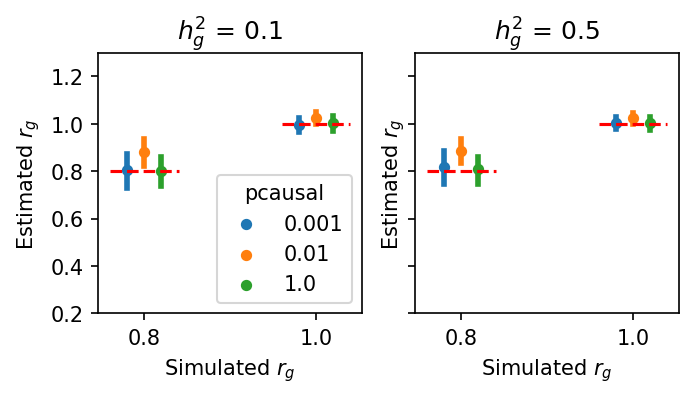

In [29]:
rls_list = []

for hsq in [0.1, 0.5]:
    for pcausal in [0.01, 0.001, 1.0]:
        for cor in [0.8, 1.0]:
            for hermodel in ["mafukb"]:
                f_name = (
                    f"out/estimate/hsq-{hsq}-pcausal-{pcausal}-cor-{cor}"
                    + f"-hermodel-{hermodel}.estimate.json"
                )
                if not os.path.exists(f_name):
                    continue
                with open(f_name) as f:
                    data = json.load(f)

                    df_tmp = pd.DataFrame(
                        np.array([d["estimate"] for d in data]),
                        columns=[
                            "estimated_var_g",
                            "estimated_rho",
                            "estimated_var_e",
                        ],
                    )
                    df_tmp["hsq"] = hsq
                    df_tmp["cor"] = cor
                    df_tmp["pcausal"] = pcausal
                    df_tmp["hermodel"] = hermodel
                    rls_list.append(df_tmp)

df_plot = pd.concat(rls_list)
df_plot["estimated_ratio"] = df_plot["estimated_rho"] / df_plot["estimated_var_g"]

fig, axes = plt.subplots(figsize=(5, 2.3), dpi=150, sharex=True, sharey=True, ncols=2)

for ax_i, hsq in enumerate([0.1, 0.5]):
    df_tmp = df_plot[(df_plot.hsq == hsq)].copy()

    ax = axes[ax_i]

    sns.pointplot(
        data=df_tmp,
        x="cor",
        y="estimated_ratio",
        hue="pcausal",
        ax=ax,
        markers=".",
        dodge=0.2,
        join=False,
    )
    cor_list = sorted(df_plot.cor.unique())

    ax.hlines(
        cor_list,
        np.arange(len(cor_list)) - 0.2,
        np.arange(len(cor_list)) + 0.2,
        color="red",
        ls="--",
        zorder=10,
    )
    ax.set_ylim(0.2, 1.3)
    ax.set_xlabel("Simulated $r_g$")
    ax.set_ylabel("Estimated $r_g$")
    ax.set_title("$h_g^2$" + f" = {hsq}")
    if ax_i != 0:
        axes[ax_i].legend([], [], frameon=False)

In [30]:
df_plot.groupby(["hsq", "cor", "pcausal"]).apply(lambda x: np.std(x["estimated_ratio"]))

hsq  cor  pcausal
0.1  0.8  0.001      0.369138
          0.010      0.287760
          1.000      0.307902
     1.0  0.001      0.150013
          0.010      0.121143
          1.000      0.151657
0.5  0.8  0.001      0.343362
          0.010      0.266484
          1.000      0.290781
     1.0  0.001      0.136061
          0.010      0.118365
          1.000      0.146688
dtype: float64

# Plot GCTA

In [31]:
import admix

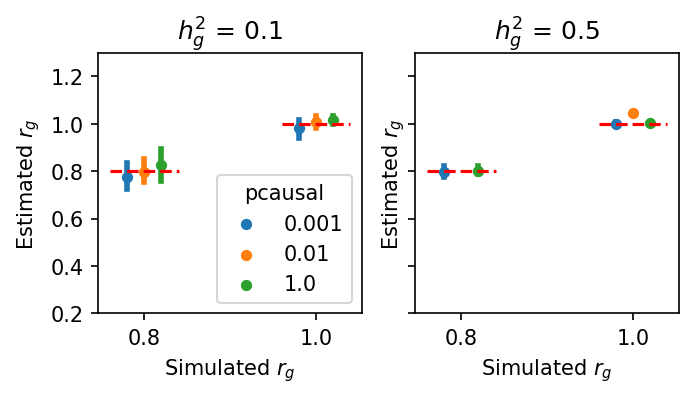

In [67]:
df_plot = []

for hsq in [0.1, 0.5]:
    for pcausal in [0.01, 0.001, 1.0]:
        for cor in [0.8, 1.0]:
            for hermodel in ["mafukb"]:
                for sim_i in range(10):
                    f_name = (
                        f"out/gcta-estimate/hsq-{hsq}-pcausal-{pcausal}-cor-{cor}"
                        + f"-hermodel-{hermodel}.sim_{sim_i}"
                    )
                    if not os.path.exists(f_name + ".hsq"):
                        continue
                    est = admix.tools.gcta.read_reml(f_name)
                    rg, rg_var = estimate_rg(
                        est["est"].Variance.values, est["varcov"].values
                    )
                    rg_stderr = np.sqrt(rg_var)
                    df_plot.append(
                        est["est"].Variance.values.tolist()
                        + [hsq, cor, pcausal, hermodel, rg, rg_stderr, sim_i]
                    )
df_plot = pd.DataFrame(
    df_plot,
    columns=[
        "estimated_var_g",
        "estimated_rho",
        "estimated_var_e",
        "hsq",
        "cor",
        "pcausal",
        "hermodel",
        "estimated_ratio",
        "estimated_ratio_stderr",
        "sim_i",
    ],
)

df_plot = df_plot[df_plot.estimated_ratio_stderr < 0.2]
fig, axes = plt.subplots(figsize=(5, 2.3), dpi=150, sharex=True, sharey=True, ncols=2)

for ax_i, hsq in enumerate([0.1, 0.5]):
    df_tmp = df_plot[(df_plot.hsq == hsq)].copy()

    ax = axes[ax_i]

    sns.pointplot(
        data=df_tmp,
        x="cor",
        y="estimated_ratio",
        hue="pcausal",
        ax=ax,
        markers=".",
        dodge=0.2,
        join=False,
    )
    cor_list = sorted(df_plot.cor.unique())

    ax.hlines(
        cor_list,
        np.arange(len(cor_list)) - 0.2,
        np.arange(len(cor_list)) + 0.2,
        color="red",
        ls="--",
        zorder=10,
    )
    ax.set_ylim(0.2, 1.3)
    ax.set_xlabel("Simulated $r_g$")
    ax.set_ylabel("Estimated $r_g$")
    ax.set_title("$h_g^2$" + f" = {hsq}")
    if ax_i != 0:
        axes[ax_i].legend([], [], frameon=False)

In [68]:
df_plot.groupby(["hsq", "cor", "pcausal"]).apply(lambda x: np.std(x["estimated_ratio"]))

hsq  cor  pcausal
0.1  0.8  0.001      0.085816
          0.010      0.077078
          1.000      0.110568
     1.0  0.001      0.056524
          0.010      0.041983
          1.000      0.029737
0.5  0.8  0.001      0.037821
          1.000      0.027576
     1.0  0.001      0.012207
          0.010      0.000000
          1.000      0.007730
dtype: float64

In [69]:
df_plot.groupby(["hsq", "cor", "pcausal"]).apply(lambda x: len(x["estimated_ratio"]))

hsq  cor  pcausal
0.1  0.8  0.001      10
          0.010      10
          1.000      10
     1.0  0.001       9
          0.010      10
          1.000      10
0.5  0.8  0.001      10
          1.000      10
     1.0  0.001      10
          0.010       1
          1.000      10
dtype: int64

In [70]:
df_plot.groupby(["hsq", "cor", "pcausal"]).apply(
    lambda x: np.mean(x["estimated_ratio_stderr"])
)

hsq  cor  pcausal
0.1  0.8  0.001      0.089817
          0.010      0.092502
          1.000      0.081496
     1.0  0.001      0.048680
          0.010      0.040887
          1.000      0.036331
0.5  0.8  0.001      0.029347
          1.000      0.029563
     1.0  0.001      0.011338
          0.010      0.138806
          1.000      0.011096
dtype: float64

In [54]:
hsq = 0.5
cor = 0.8
pcausal = 0.01
hermodel = "mafukb"
sim_i = 6
f_name = (
    f"out/gcta-estimate/hsq-{hsq}-pcausal-{pcausal}-cor-{cor}"
    + f"-hermodel-{hermodel}.sim_{sim_i}"
)
est = admix.tools.gcta.read_reml(f_name)

In [55]:
y, x = est["est"].Variance[0:2]
var_x = est["varcov"].values[1, 1]
var_y = est["varcov"].values[0, 0]
cov_xy = est["varcov"].values[0, 1]

In [57]:
estimate_rg(est["est"].Variance.values, est["varcov"].values)

(0.318145403564991, 0.2779991989870196)

In [ ]:
def estimate_rg(est, est_var):
    """
    Estimate the ratio of genetic correlation.
    est: (3, ) numpy array
    est_var (3, 3) variance-covariance matrix
    """
    x, y = est[0], est[1]
    rg = y / x
    # grad = [-y / x^2, 1 / x]
    grad = np.array([-y / (x ** 2), 1 / x])

    def quad_form(x, A):
        return np.dot(np.dot(x.T, A), x)

    return rg, quad_form(grad, est_var[0:2, 0:2])